# Mini-Project 2
**Author**: Farkhad Kuanyshkereyev<br>
**Course**: Machine Learning<br>
**Professor**: Sepinoud Azimi Rashti

## **Step 1 - Importing Packages**

In [1]:
# Installing necessary packages

!pip install contractions

In [2]:
# Importing necessary packages and defining useful constants

from google.colab import files
from IPython.display import SVG
from keras.layers import Conv1D, Flatten, GlobalMaxPooling1D, LSTM
from keras.layers.core import Dense
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot
from nltk import word_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

import contractions
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import tensorflow as tf

nltk.download('punkt')

SEED = 0
THRESHOLD = 0.5

np.random.seed(SEED)
tf.random.set_seed(SEED)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Step 2 - Data Processing**

In [3]:
# Uploading the dataset TSV file

file_name = "Sentiment140.tenPercent.sample.tweets.tsv"
files.upload()

df = pd.read_csv(f"./{file_name}", sep="\t")

In [4]:
# Checking for missing values

df.isna().values.any()

False

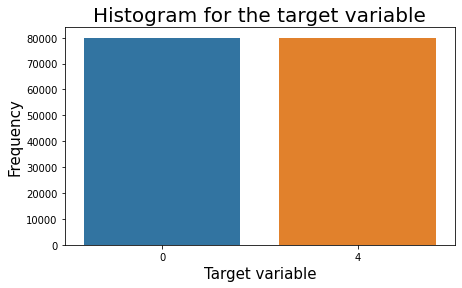

In [5]:
# Checking the class distribution

plt.subplots(figsize=(7, 4))
sns.countplot(x="sentiment_label", data=df)
plt.title("Histogram for the target variable", fontsize=20)
plt.xlabel("Target variable", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.show();

In [6]:
# Defining the tweet preprocessing function

def preprocess_tweet(tweet):
    tokenized_tweet = [contractions.fix(word) for word in tweet.split()]
    tokenized_tweet = ' '.join(tokenized_tweet).lower()
    tokenized_tweet = re.sub(r'[^\w\d\s\']+', '', tokenized_tweet)
    tokenized_tweet = word_tokenize(tokenized_tweet)
    tokenized_tweet = ' '.join(tokenized_tweet)
    return tokenized_tweet

In [7]:
# Creating the dataset of preprocessed tweets

X = []
tweets = list(df["tweet_text"])

for tweet in tweets:
    X.append(preprocess_tweet(tweet))

In [8]:
# Mapping the values of target variable y to 0 and 1 instead of 0 and 4

y = df["sentiment_label"]
y = np.array(list(map(lambda x: 1 if x == 4 else 0, y)))

In [9]:
# Creating 3 separate datasets: train, validation, and test

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5, random_state=SEED)

In [10]:
# Tokenizing words in tweets and converting them to dictionary numbers

tokenizer = Tokenizer(num_words=4096)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_test  = tokenizer.texts_to_sequences(X_test)

In [11]:
# Padding sequences of tokenized tweets

vocab_size = len(tokenizer.word_index) + 1
maxlen = 128

X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
X_valid = pad_sequences(X_valid, padding="post", maxlen=maxlen)
X_test  = pad_sequences(X_test, padding="post", maxlen=maxlen)

## **Step 3 - CNN Model**

### **Step 3.1 - Training**

In [12]:
# Defining the CNN model

model = Sequential()

model.add(Embedding(vocab_size, 32, input_length=maxlen))
model.add(Conv1D(32, 5, activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer="adam"
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 32)           4182464   
                                                                 
 conv1d (Conv1D)             (None, 124, 32)           5152      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,187,649
Trainable params: 4,187,649
Non-trainable params: 0
_________________________________________________________________


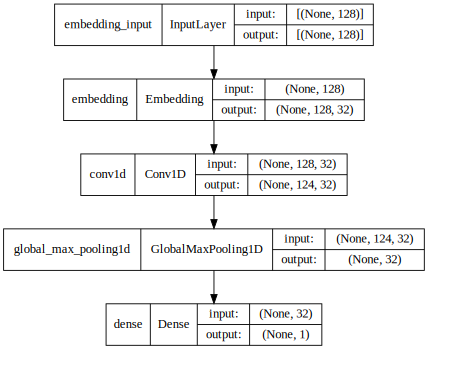

In [13]:
# Showing the architecture of the model

SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog="dot", format="svg"))

In [14]:
# Fitting the model

history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(X_valid, y_valid)
)

Epoch 1/5
1000/1000 [==============================] - 74s 73ms/step - loss: 0.5004 - accuracy: 0.7557 - val_loss: 0.4527 - val_accuracy: 0.7881
Epoch 2/5
1000/1000 [==============================] - 73s 73ms/step - loss: 0.4303 - accuracy: 0.8019 - val_loss: 0.4406 - val_accuracy: 0.7934
Epoch 3/5
1000/1000 [==============================] - 72s 72ms/step - loss: 0.4031 - accuracy: 0.8174 - val_loss: 0.4414 - val_accuracy: 0.7938
Epoch 4/5
1000/1000 [==============================] - 72s 72ms/step - loss: 0.3773 - accuracy: 0.8324 - val_loss: 0.4457 - val_accuracy: 0.7933
Epoch 5/5
1000/1000 [==============================] - 72s 72ms/step - loss: 0.3506 - accuracy: 0.8472 - val_loss: 0.4594 - val_accuracy: 0.7919


### **Step 3.2 - Performance Evaluation**

In [15]:
# Defining visualization functions

def plot_performance_evaluation(history, metric, model_name):
    training_values = history.history[metric.lower()]
    test_values = history.history[f"val_{metric.lower()}"]
    epoch_count = range(1, len(training_values) + 1)

    plt.subplots(figsize=(7, 4))
    plt.plot(epoch_count, training_values, "r--")
    plt.plot(epoch_count, test_values, "b-")
    plt.title(f"{metric} Plot for {model_name}", fontsize=20)
    plt.legend([f"Training {metric}", f"Test {metric}"], fontsize=15)
    plt.xticks(epoch_count)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel(metric, fontsize=15)
    plt.grid()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name):
    cf_matrix = confusion_matrix(y_true, y_pred > THRESHOLD)

    plt.subplots(figsize=(7, 4))
    sns.heatmap(cf_matrix, annot=True, fmt='g')
    plt.title(f"Confusion matrix for {model_name}", fontsize=20)
    plt.xlabel("True labels", fontsize=15)
    plt.ylabel("Predicted labels", fontsize=15)
    plt.show()

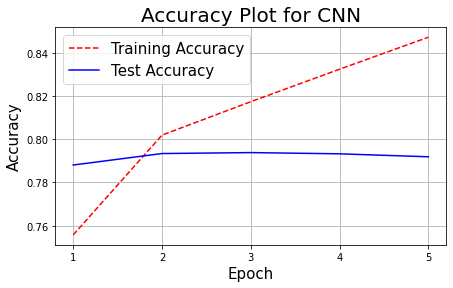

In [16]:
# Showing the accuracy plot

plot_performance_evaluation(history, "Accuracy", "CNN")

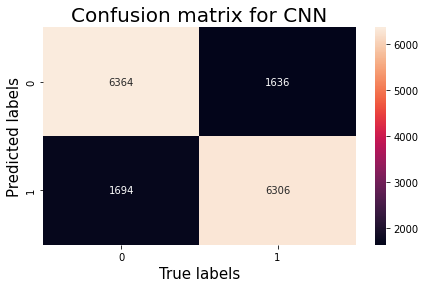

In [18]:
# Visualizing the confusion matrix for the target variable

y_pred = model.predict(X_valid)
plot_confusion_matrix(y_valid, y_pred, "CNN")

In [19]:
# Finding the accuracy score for the validation dataset

accuracy = accuracy_score(y_valid, y_pred > THRESHOLD)
print("Accuracy for the validation dataset: %.2f %%" % (accuracy * 100))

Accuracy for the validation dataset: 79.19 %


In [20]:
# Finding the accuracy score for the test dataset

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred > THRESHOLD)
print("Accuracy for the test dataset: %.2f %%" % (accuracy * 100))

Accuracy for the test dataset: 78.84 %


## **Step 4 - RNN Model**

### **Step 4.1 - Training**

In [21]:
# Defining the RNN model

model = Sequential()

model.add(Embedding(vocab_size, 32, input_length=maxlen))
model.add(LSTM(32, activation="relu", return_sequences=True))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy", 
    metrics=["accuracy"],
    optimizer="adam"
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 128, 32)           4182464   
                                                                 
 lstm (LSTM)                 (None, 128, 32)           8320      
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 4097      
                                                                 
Total params: 4,194,881
Trainable params: 4,194,881
Non-trainable params: 0
_________________________________________________________________


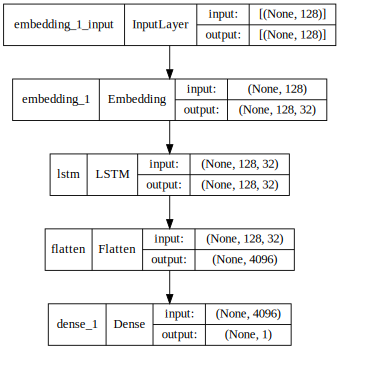

In [22]:
# Showing the architecture of the model

SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog="dot", format="svg"))

In [23]:
# Fitting the model

history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(X_valid, y_valid)
)

Epoch 1/5
1000/1000 [==============================] - 119s 118ms/step - loss: 2804112.5000 - accuracy: 0.7123 - val_loss: 0.5141 - val_accuracy: 0.7582
Epoch 2/5
1000/1000 [==============================] - 119s 119ms/step - loss: 0.5002 - accuracy: 0.7629 - val_loss: 0.5051 - val_accuracy: 0.7599
Epoch 3/5
1000/1000 [==============================] - 132s 132ms/step - loss: 0.4877 - accuracy: 0.7702 - val_loss: 0.5007 - val_accuracy: 0.7629
Epoch 4/5
1000/1000 [==============================] - 121s 121ms/step - loss: 0.4796 - accuracy: 0.7741 - val_loss: 0.4987 - val_accuracy: 0.7631
Epoch 5/5
1000/1000 [==============================] - 119s 119ms/step - loss: 0.4726 - accuracy: 0.7784 - val_loss: 0.4979 - val_accuracy: 0.7622


### **Step 4.2 - Performance Evaluation**

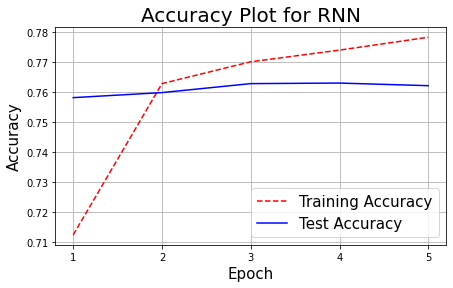

In [24]:
# Showing the accuracy plot

plot_performance_evaluation(history, "Accuracy", "RNN")

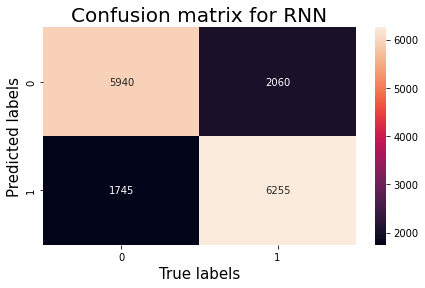

In [26]:
# Visualizing the confusion matrix for the target variable

y_pred = model.predict(X_valid)
plot_confusion_matrix(y_valid, y_pred, "RNN")

In [27]:
# Finding the accuracy score for the validation dataset

accuracy = accuracy_score(y_valid, y_pred > THRESHOLD)
print("Accuracy for the validation dataset: %.2f %%" % (accuracy * 100))

Accuracy for the validation dataset: 76.22 %


In [28]:
# Finding the accuracy score for the test dataset

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred > THRESHOLD)
print("Accuracy for the test dataset: %.2f %%" % (accuracy * 100))

Accuracy for the test dataset: 76.29 %
